# Demo - AI 4 Parameterization

We want to use temperature to predict relative humidity.

**Yes**: we already know that they are easy to calculate but we just want to demonstrate the pipeline

In [1]:
import autoroot
import numpy as np
import xarray as xr
import sklearn
import matplotlib.pyplot as plt
import einops
import seaborn as sns
import cartopy.crs as ccrs
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Physical Processes

$$
\text{Relative Humidity} = \boldsymbol{f} \left( \text{Temperature};\boldsymbol{\theta}\right)
$$

# Data

First, we need some data. 
For example, ERA5.

In [2]:
# local dataset
save_name = "reanalysis_20180715_20180830_ics_v2"

file_paths = [
    f"/pool/proyectos/CLINT/sa4attrs/data/raw/events/{save_name}.nc"
]

ds_true = xr.open_mfdataset(file_paths, engine="netcdf4")

## Representation

* Pixel
* Surface Only

$$
\boldsymbol{u} = \boldsymbol{f}(\boldsymbol{x};\boldsymbol{\theta})
$$

$$
\begin{aligned}
\text{Relative Humidity}: && &&
\boldsymbol{u}&\in\mathbb{R} \\
\text{Temperature}: && &&
\boldsymbol{x}&\in\mathbb{R}
\end{aligned}
$$

In [3]:
# select variables
variables = ["2m_temperature", "relative_humidity"]
ds = ds_true[variables]
# select level
ds = ds.sel(level=1000)
# select region
# ds["longitude"] = ds.longitude.values % 360
ds = ds.sel(latitude=slice(-20,-55), longitude=slice(280,320))

In [4]:
# ds["2m_temperature"].isel(time=0).plot.pcolormesh()

In [5]:
# ds["relative_humidity"].isel(time=0).plot.pcolormesh()

In [6]:
x = ds["2m_temperature"].values
u = ds["relative_humidity"].values

shape = x.shape
# need a vector
x = einops.rearrange(x, "T H W -> (T H W) 1")
u = einops.rearrange(u, "T H W -> (T H W) 1")

## Example Model - Linear Regression

[Source- scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)

In [7]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha=.5)
reg.fit(x, u)

Ridge(alpha=0.5)

In [8]:
reg.coef_, reg.alpha

(array([[0.00722878]], dtype=float32), 0.5)

In [9]:
u_pred = reg.predict(x)


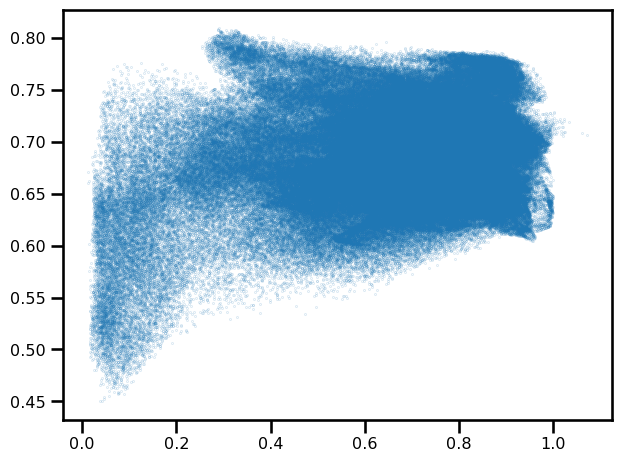

In [33]:
fig, ax = plt.subplots()

ax.scatter(u, u_pred, s=0.01)

plt.tight_layout()

(0.012664761261266168, 1.071846154651143)

In [12]:
u_pred = u_pred.reshape(shape)
ds["rh_pred"] = (("time", "latitude", "longitude"), u_pred)

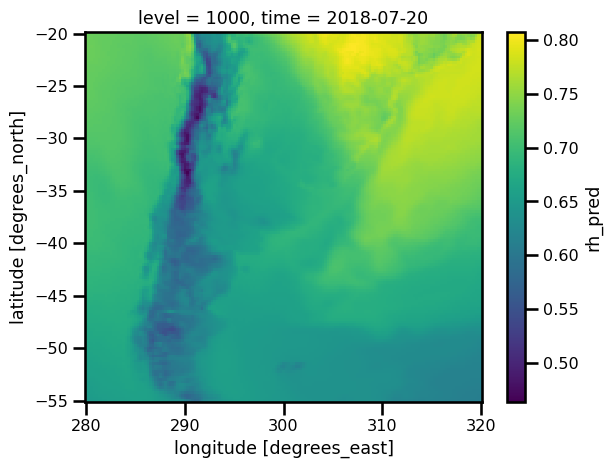

In [13]:
ds["rh_pred"].isel(time=0).plot.pcolormesh()

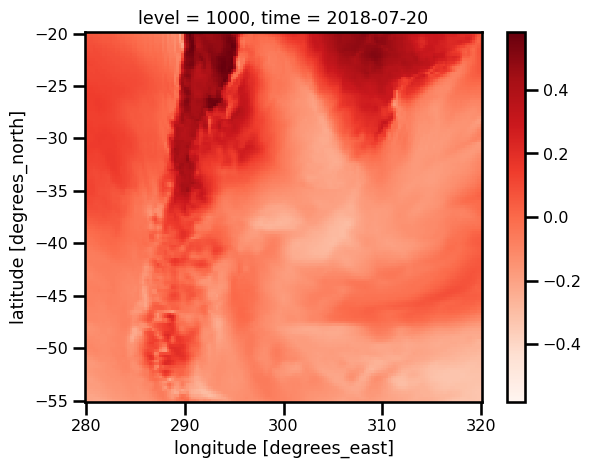

In [14]:
(ds["rh_pred"] - ds["relative_humidity"]).isel(time=0).plot.pcolormesh(cmap="Reds")

## Train Test

## Example: Neural Network

[Source](https://keras.io/getting_started/intro_to_keras_for_engineers/#introduction-to-keras-for-engineers)

In [16]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras


In [17]:
input_shape = (1,)

In [18]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1),
    ]
)

In [19]:
out = model(x[:10])
out.shape

torch.Size([10, 1])

In [20]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.MeanSquaredError(name="mse"),
    ],
)


In [21]:
batch_size = 128
epochs = 20

callbacks = [
    # keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

results = model.fit(
    x,
    u,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)
# score = model.evaluate(x_test, y_test, verbose=0)


Epoch 1/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.8868 - mse: 0.8868 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 2/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 3/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 4/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 5/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0416 - val_mse: 0.0416
Epoch 6/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0416 - val_mse: 0.0416


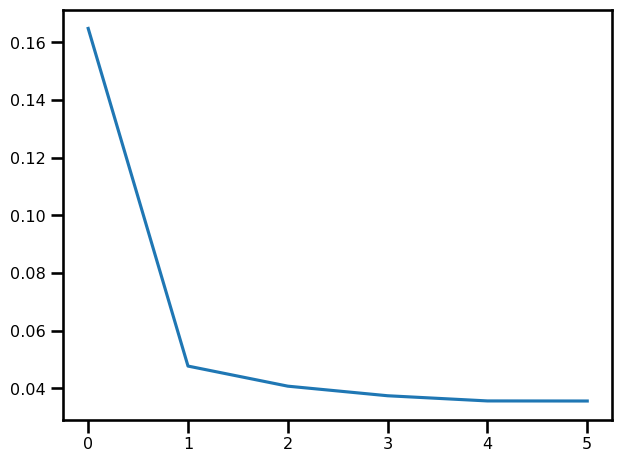

In [22]:
fig, ax = plt.subplots()

ax.plot(results.history["loss"])
plt.tight_layout()
plt.show()


In [25]:
model.evaluate(x, u, verbose=0, batch_size=100)

[0.03703509271144867, 0.037034772336483]

In [26]:
u_pred = model.predict(x, verbose=0, batch_size=100)

In [27]:
u_pred = reg.predict(x)
u_pred = u_pred.reshape(shape)

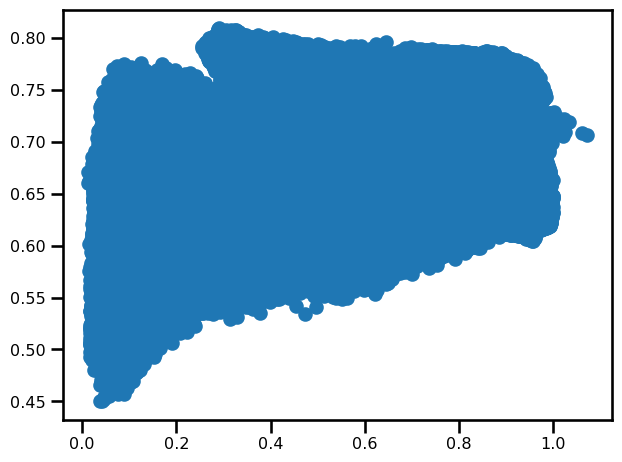

In [28]:
fig, ax = plt.subplots()

ax.scatter(u, u_pred)

plt.tight_layout()

In [30]:
ds["rh_pred_nn"] = (("time", "latitude", "longitude"), u_pred)

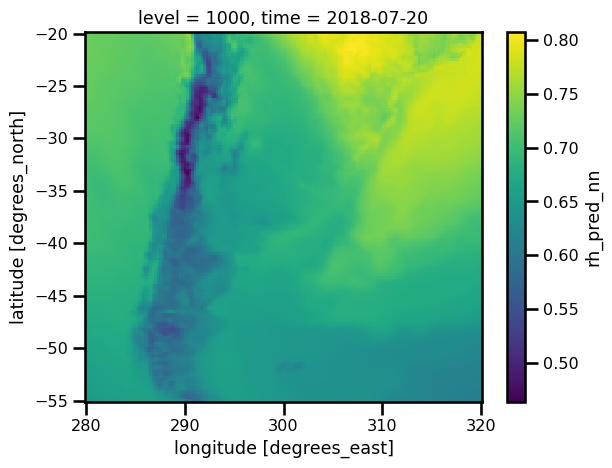

In [31]:
ds["rh_pred_nn"].isel(time=0).plot.pcolormesh()

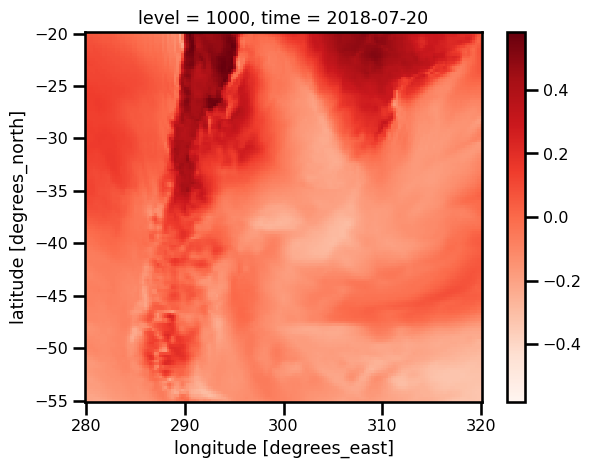

In [32]:
(ds["rh_pred_nn"] - ds["relative_humidity"]).isel(time=0).plot.pcolormesh(cmap="Reds")